In [152]:
#import packages 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#machine learning clustering k-means
from sklearn.cluster import KMeans
#3D clustering 
import plotly
import plotly.graph_objs as go

%matplotlib inline
sns.set_style('ticks')

pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
#load data
df = pd.read_csv('../data/outputs/ident_obs_single_combined.csv')

In [156]:
df_ = pd.read_csv('../data/outputs/ident_obs_clusters.csv')
df_.shape

(22827, 8)

In [3]:
df.head()

,Unnamed: 0,user_id,obs_count,ident_count,city,year
0,0,353381,567.0,7.0,London,2018
1,1,664459,150.0,24.0,London,2018
2,2,911337,125.0,1.0,London,2018
3,3,883351,97.0,1.0,London,2018
4,4,781146,95.0,1.0,London,2018


In [4]:
df=df.drop(['Unnamed: 0'], axis=1)

In [5]:
df.head()

,user_id,obs_count,ident_count,city,year
0,353381,567.0,7.0,London,2018
1,664459,150.0,24.0,London,2018
2,911337,125.0,1.0,London,2018
3,883351,97.0,1.0,London,2018
4,781146,95.0,1.0,London,2018


In [6]:
df.shape

(22827, 5)

## Cleaning

In [7]:
df.isna().sum()

user_id           0
obs_count      9402
ident_count    2030
city              0
year              0
dtype: int64

In [8]:
df.replace('',np.nan).isna().sum()

user_id           0
obs_count      9402
ident_count    2030
city              0
year              0
dtype: int64

In [9]:
df.replace(' ',np.nan).isna().sum()

user_id           0
obs_count      9402
ident_count    2030
city              0
year              0
dtype: int64

In [10]:
df.dtypes

user_id          int64
obs_count      float64
ident_count    float64
city            object
year             int64
dtype: object

### Replace NANs with 0

In [11]:
df=df.fillna(0)

In [12]:
df.isna().sum()

user_id        0
obs_count      0
ident_count    0
city           0
year           0
dtype: int64

In [13]:
df['city'].value_counts()

San Francisco    11723
Los Angeles       8985
London            2119
Name: city, dtype: int64

## Inspect

In [14]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
user_id,22827.0,1.089444e+06,902109.977771,1.0,378990.5,858099.0,1668919.0,3809444.0
obs_count,22827.0,1.071411e+01,47.623937,0.0,0.0,1.0,4.0,1414.0
ident_count,22827.0,5.550488e+00,24.223087,0.0,1.0,1.0,2.0,910.0
year,22827.0,2.018788e+03,1.058339,2017.0,2018.0,2019.0,2020.0,2020.0


In [15]:
#step before log transformation to avoid the zeros 
df['obs_count_1']=df['obs_count']+1
df['ident_count_1']=df['ident_count']+1

In [16]:
#log transform
df['obs_count_log'] = np.log(df['obs_count_1'])
df['ident_count_log'] = np.log(df['ident_count_1'])

In [17]:
df.head()

,user_id,obs_count,ident_count,city,year,obs_count_1,ident_count_1,obs_count_log,ident_count_log
0,353381,567.0,7.0,London,2018,568.0,8.0,6.342121,2.079442
1,664459,150.0,24.0,London,2018,151.0,25.0,5.017280,3.218876
2,911337,125.0,1.0,London,2018,126.0,2.0,4.836282,0.693147
3,883351,97.0,1.0,London,2018,98.0,2.0,4.584967,0.693147
4,781146,95.0,1.0,London,2018,96.0,2.0,4.564348,0.693147


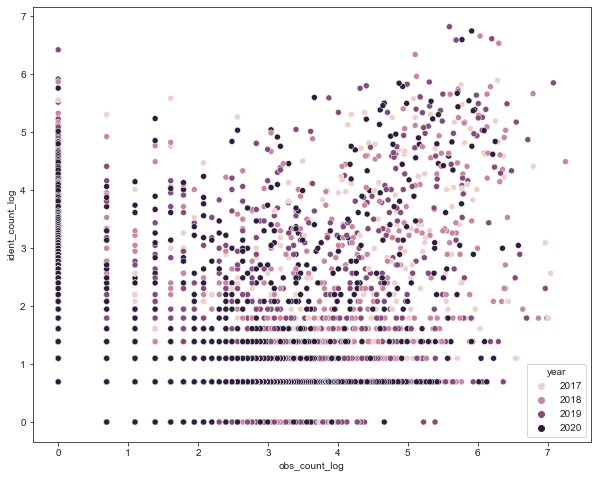

In [18]:
plt.figure(figsize=(10,8))
sns.scatterplot(data=df,
                x="obs_count_log",
                y="ident_count_log",
                hue="year");

In [19]:
def plot_2d(df, x, y, hue):
    plt.figure(figsize=(10,8))
    sns.scatterplot(data=df,
                    x=x,
                    y=y,
                    hue=hue,
                    #style=hue,
                    palette='rainbow');
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

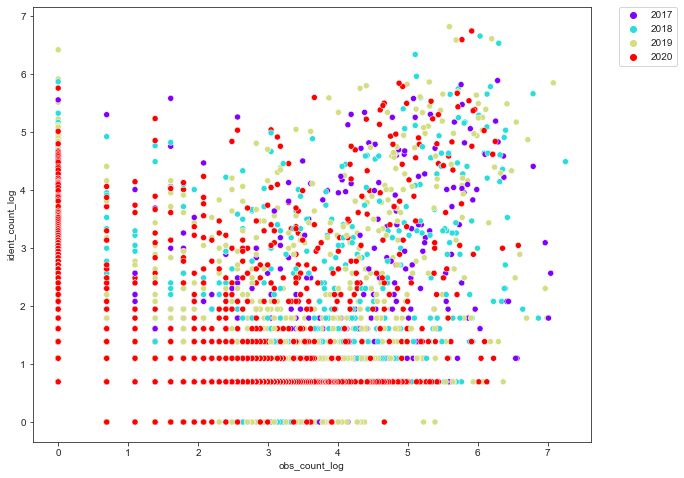

In [20]:
plot_2d(df, "obs_count_log", "ident_count_log", "year")

## 2D clustering based on number of observations and number of identifications

In [21]:
X = df[['obs_count_log', 'ident_count_log']]
clusters = KMeans(n_clusters=2, n_init=1).fit(X)

In [22]:
X

,obs_count_log,ident_count_log
0,6.342121,2.079442
1,5.017280,3.218876
2,4.836282,0.693147
3,4.584967,0.693147
4,4.564348,0.693147
...,...,...
22822,0.000000,0.693147
22823,0.000000,0.693147
22824,0.000000,0.693147
22825,0.000000,0.693147


In [23]:
clusters.predict(X)

array([0, 0, 0, ..., 1, 1, 1])

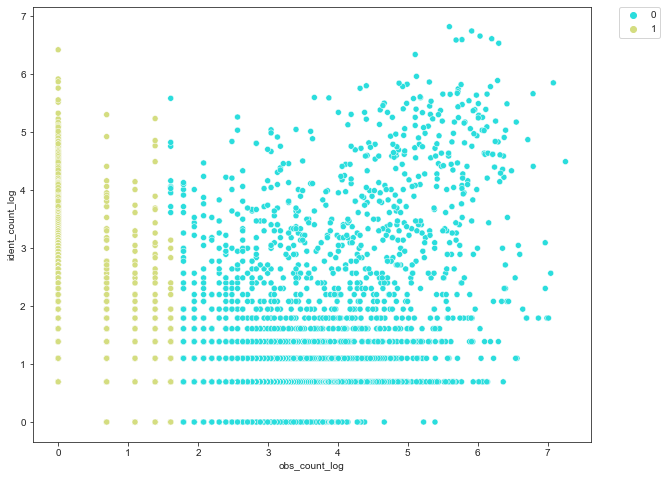

In [24]:
plot_2d(df, "obs_count_log", "ident_count_log", clusters.predict(X))

## Determining optimal number of clusters using the elbow method 

In [25]:
X1 = df[["obs_count_log", "ident_count_log"]]
clusters1 = KMeans(n_clusters=2, n_init=10, init="random").fit(X1)

In [26]:
clusters1.inertia_

28985.19806089929

In [27]:
def plot_elbow(df, dims):
    results = []
    for i in range(10):
        X_n = df[dims]
        clusters_n = KMeans(n_clusters=i+1, n_init=10, init="random").fit(X_n)
        results.append({"n": i+1,
                        "inertia": clusters_n.inertia_})
    elbow_plot = pd.DataFrame(results)
    
    plt.figure(figsize=(12,8))
    sns.lineplot(data=elbow_plot,
                 x="n",
                 y="inertia");
    plt.title("Optimal Number of Clusters");

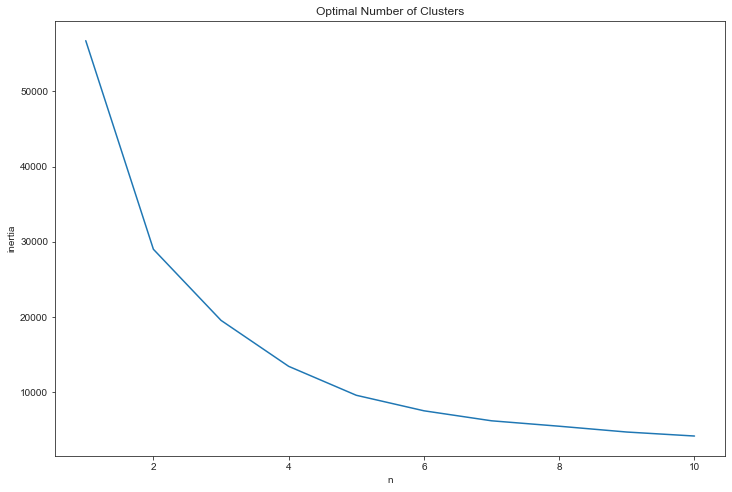

In [28]:
plot_elbow(df, ["obs_count_log", "ident_count_log"])

In [49]:
clusters_ = KMeans(n_clusters=4, n_init=10, init="k-means++", max_iter=300, random_state=42).fit(X)

In [30]:
def cluster_2d(df, x, y, n_clusters=4):
    X = df[[x, y]]
    clusters = KMeans(n_clusters=n_clusters, n_init=10, init="k-means++", max_iter=300, random_state=42).fit(X)
    plot_2d(df, x, y, clusters.predict(X))

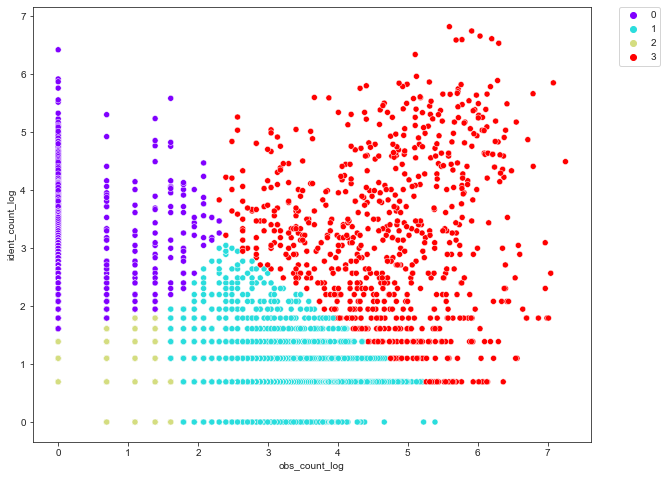

In [31]:
cluster_2d(df, "obs_count_log", "ident_count_log", 4)

### It looks better with 4 clusters.

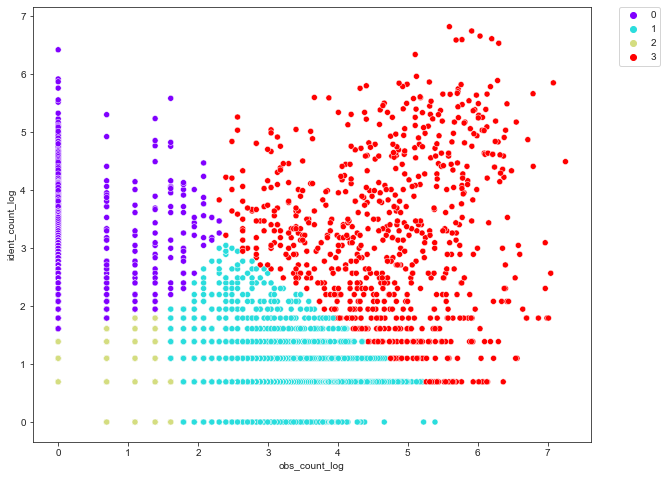

In [32]:
cluster_2d(df, "obs_count_log", "ident_count_log", 4)

In [50]:
df['cluster_id'] = clusters_.labels_

In [34]:
#df['cluster_id'].value_counts()

In [35]:
df.head()

,user_id,obs_count,ident_count,city,year,obs_count_1,ident_count_1,obs_count_log,ident_count_log
0,353381,567.0,7.0,London,2018,568.0,8.0,6.342121,2.079442
1,664459,150.0,24.0,London,2018,151.0,25.0,5.017280,3.218876
2,911337,125.0,1.0,London,2018,126.0,2.0,4.836282,0.693147
3,883351,97.0,1.0,London,2018,98.0,2.0,4.584967,0.693147
4,781146,95.0,1.0,London,2018,96.0,2.0,4.564348,0.693147


### Describe the clusters

In [36]:
df_as = df.assign(cluster=(KMeans(n_clusters=4, n_init=10, init="random")
                           .fit(df[["obs_count_log", "ident_count_log"]])
                           .predict(df[["obs_count_log", "ident_count_log"]])))

In [37]:
df_as.drop(["user_id", "year", "obs_count", "ident_count", "obs_count_1", "ident_count_1"], axis=1).groupby("cluster").describe().transpose()

cluster                          0            1             2           3
obs_count_log   count  5263.000000  2731.000000  13953.000000  880.000000
                mean      2.558415     0.073864      0.446725    4.678250
                std       0.738186     0.320587      0.474799    0.969248
                min       1.609438     0.000000      0.000000    2.397895
                25%       1.945910     0.000000      0.000000    4.077537
                50%       2.397895     0.000000      0.693147    4.740565
                75%       3.091042     0.000000      0.693147    5.364789
                max       5.389072     2.302585      1.386294    7.254885
ident_count_log count  5263.000000  2731.000000  13953.000000  880.000000
                mean      0.757855     2.700529      0.730190    2.881850
                std       0.367222     0.799187      0.361664    1.455229
                min       0.000000     1.791759      0.000000    0.693147
                25%       0.693147     2.079442      0.693147    1.609438
                50%       0.693147     2.484907      0.693147    2.772589
                75%       0.693147     3.135494      0.693147    3.993571
                max       2.944439     6.416732      1.791759    6.814543

# Now, we can follow the same steps for the three different cities

In [38]:
df['city'].value_counts()

San Francisco    11723
Los Angeles       8985
London            2119
Name: city, dtype: int64

In [39]:
df['year'].value_counts()

2020    7369
2019    6745
2018    5208
2017    3505
Name: year, dtype: int64

In [40]:
#SF
df_sf_20=df[df['city'].eq('San Francisco') & df['year'].eq(2020)]
df_sf_19=df[df['city'].eq('San Francisco') & df['year'].eq(2019)]
df_sf_18=df[df['city'].eq('San Francisco') & df['year'].eq(2018)]
df_sf_17=df[df['city'].eq('San Francisco') & df['year'].eq(2017)]
#LA
df_la_20=df[df['city'].eq('Los Angeles') & df['year'].eq(2020)]
df_la_19=df[df['city'].eq('Los Angeles') & df['year'].eq(2019)]
df_la_18=df[df['city'].eq('Los Angeles') & df['year'].eq(2018)]
df_la_17=df[df['city'].eq('Los Angeles') & df['year'].eq(2017)]
#LDN
df_ldn_20=df[df['city'].eq('London') & df['year'].eq(2020)]
df_ldn_19=df[df['city'].eq('London') & df['year'].eq(2019)]
df_ldn_18=df[df['city'].eq('London') & df['year'].eq(2018)]
#no data for London in 2017
#df_ldn_17=df[df['city'].eq('London') & df['year'].eq(2017)]

In [122]:
#SF
X_sf_20 = df_sf_20[['obs_count_log', 'ident_count_log']]
X_sf_19 = df_sf_19[['obs_count_log', 'ident_count_log']]
X_sf_18 = df_sf_18[['obs_count_log', 'ident_count_log']]
X_sf_17 = df_sf_17[['obs_count_log', 'ident_count_log']]
#LA
X_la_20 = df_la_20[['obs_count_log', 'ident_count_log']]
X_la_19 = df_la_19[['obs_count_log', 'ident_count_log']]
X_la_18 = df_la_18[['obs_count_log', 'ident_count_log']]
X_la_17 = df_la_17[['obs_count_log', 'ident_count_log']]
#LDN
X_ldn_20 = df_ldn_20[['obs_count_log', 'ident_count_log']]
X_ldn_19 = df_ldn_19[['obs_count_log', 'ident_count_log']]
X_ldn_18 = df_ldn_18[['obs_count_log', 'ident_count_log']]
#X_ldn_17 = df_ldn_17[['obs_count_log', 'ident_count_log']]

In [123]:
#SF
clusters_sf_20 = KMeans(n_clusters=4, n_init=10, init="k-means++", max_iter=300, random_state=42).fit(X_sf_20)
clusters_sf_19 = KMeans(n_clusters=4, n_init=10, init="k-means++", max_iter=300, random_state=42).fit(X_sf_19)
clusters_sf_18 = KMeans(n_clusters=4, n_init=10, init="k-means++", max_iter=300, random_state=42).fit(X_sf_18)
clusters_sf_17 = KMeans(n_clusters=4, n_init=10, init="k-means++", max_iter=300, random_state=42).fit(X_sf_17)
#LA
clusters_la_20 = KMeans(n_clusters=4, n_init=10, init="k-means++", max_iter=300, random_state=42).fit(X_la_20)
clusters_la_19 = KMeans(n_clusters=4, n_init=10, init="k-means++", max_iter=300, random_state=42).fit(X_la_19)
clusters_la_18 = KMeans(n_clusters=4, n_init=10, init="k-means++", max_iter=300, random_state=42).fit(X_la_18)
clusters_la_17 = KMeans(n_clusters=4, n_init=10, init="k-means++", max_iter=300, random_state=42).fit(X_la_17)
#LDN
clusters_ldn_20 = KMeans(n_clusters=4, n_init=10, init="k-means++", max_iter=300, random_state=42).fit(X_ldn_20)
clusters_ldn_19 = KMeans(n_clusters=4, n_init=10, init="k-means++", max_iter=300, random_state=42).fit(X_ldn_19)
clusters_ldn_18 = KMeans(n_clusters=4, n_init=10, init="k-means++", max_iter=300, random_state=42).fit(X_ldn_18)
#clusters_ldn_17 = KMeans(n_clusters=4, n_init=10, init="k-means++", max_iter=300, random_state=42).fit(X_ldn_17)

In [124]:
#SF
df_sf_20['cluster_id'] = clusters_sf_20.labels_
df_sf_19['cluster_id'] = clusters_sf_19.labels_
df_sf_18['cluster_id'] = clusters_sf_18.labels_
df_sf_17['cluster_id'] = clusters_sf_17.labels_
#LA
df_la_20['cluster_id'] = clusters_la_20.labels_
df_la_19['cluster_id'] = clusters_la_19.labels_
df_la_18['cluster_id'] = clusters_la_18.labels_
df_la_17['cluster_id'] = clusters_la_17.labels_
#LDN
df_ldn_20['cluster_id'] = clusters_ldn_20.labels_
df_ldn_19['cluster_id'] = clusters_ldn_19.labels_
df_ldn_18['cluster_id'] = clusters_ldn_18.labels_
#df_ldn_17['cluster_id'] = clusters_ldn_17.labels_

In [125]:
df_sf_20['cluster_id'].value_counts(), df_sf_19['cluster_id'].value_counts(), df_sf_18['cluster_id'].value_counts(), df_sf_17['cluster_id'].value_counts()

(0    2499
 1     802
 2     340
 3     162
 Name: cluster_id, dtype: int64, 1    1881
 2     876
 3     444
 0     102
 Name: cluster_id, dtype: int64, 0    1744
 1     699
 2     369
 3     119
 Name: cluster_id, dtype: int64, 1    1027
 3     323
 0     257
 2      79
 Name: cluster_id, dtype: int64)

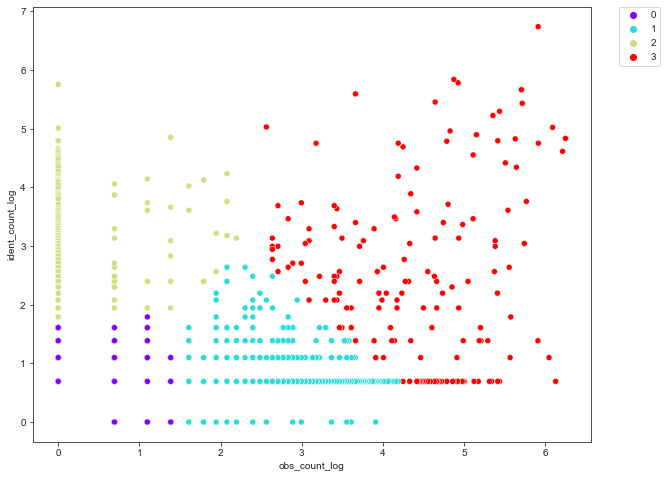

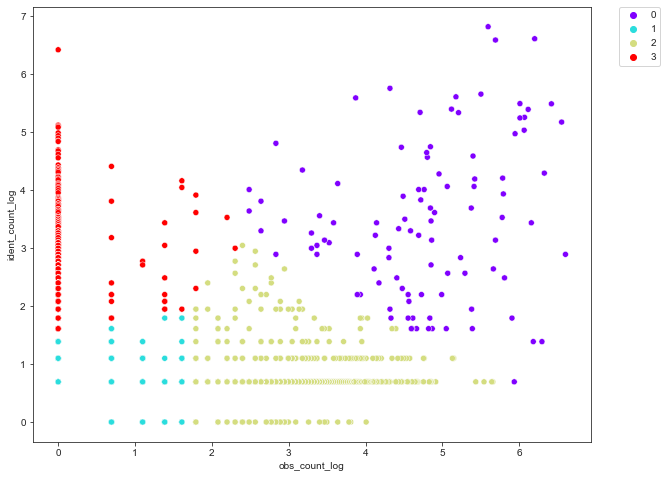

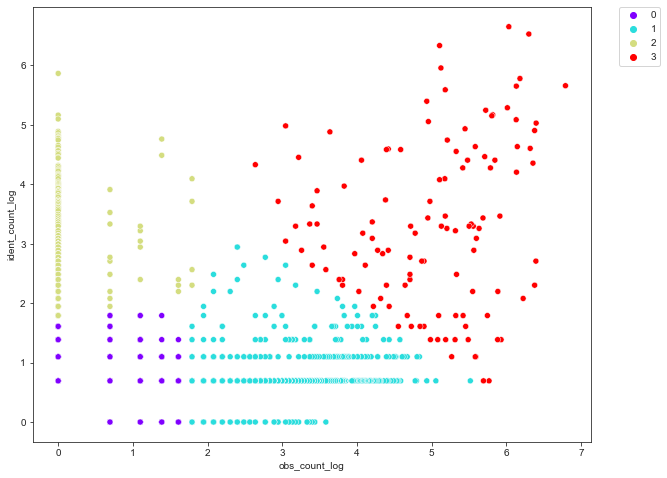

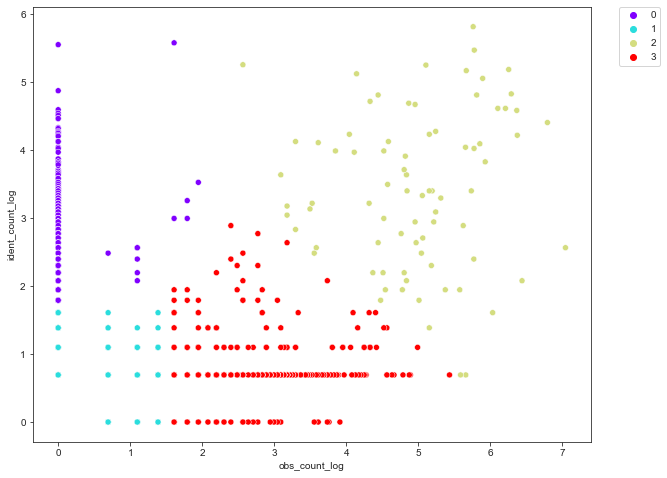

In [70]:
#san francisco
cluster_2d(df_sf_20, 'obs_count_log', 'ident_count_log', 4)
cluster_2d(df_sf_19, 'obs_count_log', 'ident_count_log', 4)
cluster_2d(df_sf_18, 'obs_count_log', 'ident_count_log', 4)
cluster_2d(df_sf_17, 'obs_count_log', 'ident_count_log', 4)

In [126]:
#la
df_la_20['cluster_id'].value_counts(), df_la_19['cluster_id'].value_counts(), df_la_18['cluster_id'].value_counts(), df_la_17['cluster_id'].value_counts()

(0    1609
 1     603
 2     284
 3      71
 Name: cluster_id, dtype: int64, 0    1541
 1     714
 2     371
 3     107
 Name: cluster_id, dtype: int64, 1    1129
 2     394
 0     257
 3      86
 Name: cluster_id, dtype: int64, 2    921
 0    552
 3    228
 1    118
 Name: cluster_id, dtype: int64)

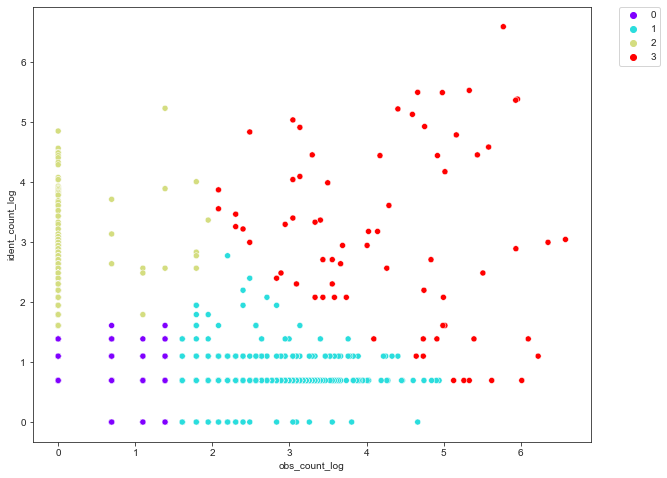

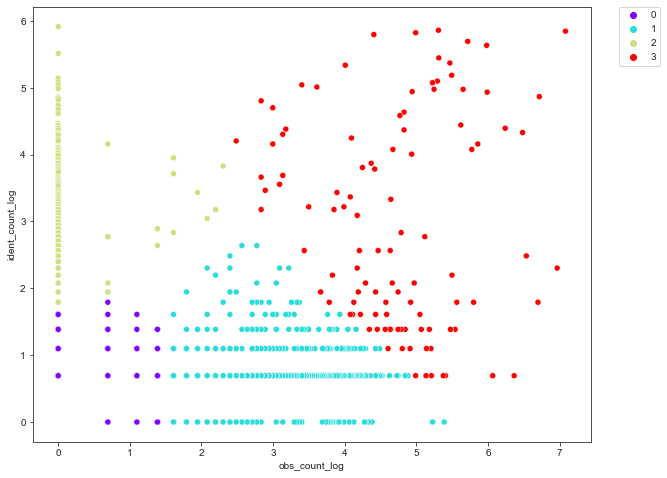

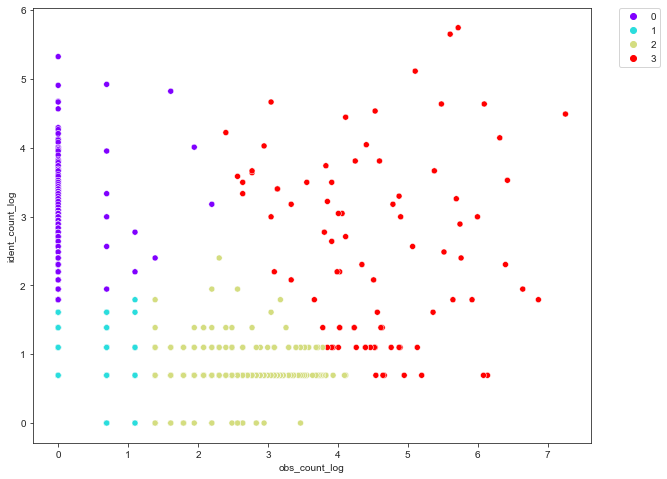

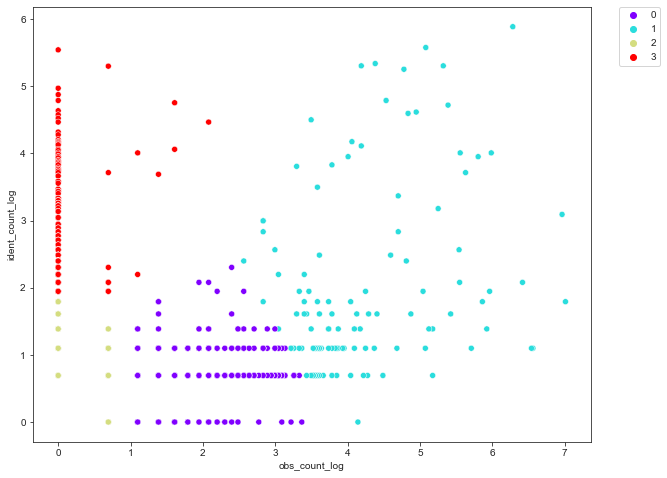

In [127]:
#la
cluster_2d(df_la_20, 'obs_count_log', 'ident_count_log', 4)
cluster_2d(df_la_19, 'obs_count_log', 'ident_count_log', 4)
cluster_2d(df_la_18, 'obs_count_log', 'ident_count_log', 4)
cluster_2d(df_la_17, 'obs_count_log', 'ident_count_log', 4)

In [129]:
#ldn
df_ldn_20['cluster_id'].value_counts(), df_ldn_19['cluster_id'].value_counts(), df_ldn_18['cluster_id'].value_counts()#, df_la_17['cluster_id'].value_counts()

(2    423
 0    321
 1    141
 3    114
 Name: cluster_id, dtype: int64, 3    327
 1    190
 0    103
 2     89
 Name: cluster_id, dtype: int64, 0    248
 3     61
 2     54
 1     48
 Name: cluster_id, dtype: int64)

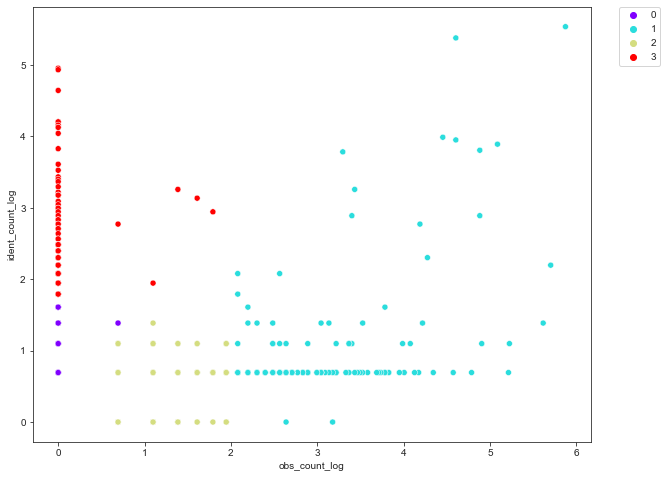

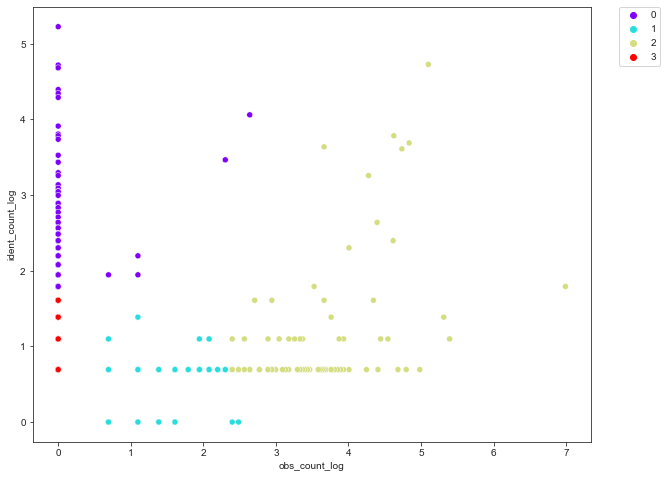

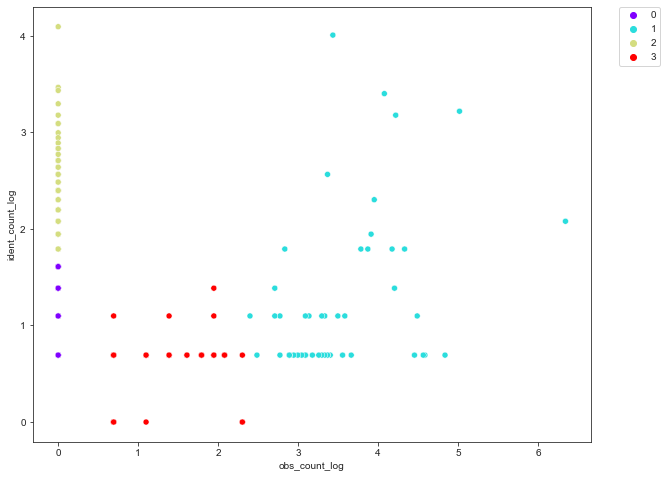

In [134]:
#ldn
cluster_2d(df_ldn_20, 'obs_count_log', 'ident_count_log', 4)
cluster_2d(df_ldn_19, 'obs_count_log', 'ident_count_log', 4)
cluster_2d(df_ldn_18, 'obs_count_log', 'ident_count_log', 4)
#cluster_2d(df_la_17, 'obs_count_log', 'ident_count_log', 4)

In [131]:
#sf
df_sf_20['cluster_count']=df_sf_20.groupby(['cluster_id'])['user_id'].transform('count')
df_sf_19['cluster_count']=df_sf_19.groupby(['cluster_id'])['user_id'].transform('count')
df_sf_18['cluster_count']=df_sf_18.groupby(['cluster_id'])['user_id'].transform('count')
df_sf_17['cluster_count']=df_sf_17.groupby(['cluster_id'])['user_id'].transform('count')
#la
df_la_20['cluster_count']=df_la_20.groupby(['cluster_id'])['user_id'].transform('count')
df_la_19['cluster_count']=df_la_19.groupby(['cluster_id'])['user_id'].transform('count')
df_la_18['cluster_count']=df_la_18.groupby(['cluster_id'])['user_id'].transform('count')
df_la_17['cluster_count']=df_la_17.groupby(['cluster_id'])['user_id'].transform('count')

In [132]:
#sf
df_sf_20['cluster_rank'] = df_sf_20['cluster_count'].rank(method='dense')
df_sf_19['cluster_rank'] = df_sf_19['cluster_count'].rank(method='dense')
df_sf_18['cluster_rank'] = df_sf_18['cluster_count'].rank(method='dense')
df_sf_17['cluster_rank'] = df_sf_17['cluster_count'].rank(method='dense')
#la
df_la_20['cluster_rank'] = df_la_20['cluster_count'].rank(method='dense')
df_la_19['cluster_rank'] = df_la_19['cluster_count'].rank(method='dense')
df_la_18['cluster_rank'] = df_la_18['cluster_count'].rank(method='dense')
df_la_17['cluster_rank'] = df_la_17['cluster_count'].rank(method='dense')

In [116]:
#function applies for all year in San Francisco and Los Angeles
def cluster_id_export_function(row):
    if row['cluster_rank'] == 4: return 'A'  #0              
    elif row['cluster_rank'] ==3: return 'C' #2    
    elif row['cluster_rank'] ==2: return 'B' #1            
    elif row['cluster_rank'] ==1: return 'D' #3
    #else: return 99                      

In [133]:
#SF
df_sf_20['cluster_id_export'] = df_sf_20.apply(cluster_id_export_function, axis=1)
df_sf_19['cluster_id_export'] = df_sf_19.apply(cluster_id_export_function, axis=1)
df_sf_18['cluster_id_export'] = df_sf_18.apply(cluster_id_export_function, axis=1)
df_sf_17['cluster_id_export'] = df_sf_17.apply(cluster_id_export_function, axis=1)
#LA
df_la_20['cluster_id_export'] = df_la_20.apply(cluster_id_export_function, axis=1)
df_la_19['cluster_id_export'] = df_la_19.apply(cluster_id_export_function, axis=1)
df_la_18['cluster_id_export'] = df_la_18.apply(cluster_id_export_function, axis=1)
df_la_17['cluster_id_export'] = df_la_17.apply(cluster_id_export_function, axis=1)

In [136]:
#function for London 2020
def cluster_id_export_function_ldn_20(row):
    if row['cluster_id'] ==0: return 'A'   #0              
    elif row['cluster_id'] ==2: return 'C' #2    
    elif row['cluster_id'] ==3: return 'B' #1            
    elif row['cluster_id'] ==1: return 'D' #3
    #else: return 99

In [137]:
#function for London 2019
def cluster_id_export_function_ldn_19(row):
    if row['cluster_id'] ==3: return 'A'   #0              
    elif row['cluster_id'] ==1: return 'C' #2    
    elif row['cluster_id'] ==0: return 'B' #1            
    elif row['cluster_id'] ==2: return 'D' #3
    #else: return 99

In [138]:
#function for London 2018
def cluster_id_export_function_ldn_18(row):
    if row['cluster_id'] ==0: return 'A'   #0              
    elif row['cluster_id'] ==3: return 'C' #2    
    elif row['cluster_id'] ==2: return 'B' #1            
    elif row['cluster_id'] ==1: return 'D' #3
    #else: return 99

In [140]:
#ldn
df_ldn_20['cluster_id_export'] = df_ldn_20.apply(cluster_id_export_function_ldn_20, axis=1)
df_ldn_19['cluster_id_export'] = df_ldn_19.apply(cluster_id_export_function_ldn_19, axis=1)
df_ldn_18['cluster_id_export'] = df_ldn_18.apply(cluster_id_export_function_ldn_18, axis=1)
#df_ldn_17['cluster_id_export'] = df_sf_17.apply(cluster_id_export_function, axis=1)

In [141]:
df_ldn_concat = pd.concat([df_ldn_20, df_ldn_19, df_ldn_18], axis=0)

In [148]:
df_ldn_concat.shape

(2119, 11)

In [143]:
df_ldn_concat['year'].value_counts()

2020    999
2019    709
2018    411
Name: year, dtype: int64

In [144]:
df_sf_la_concat = pd.concat([df_sf_20, df_sf_19, df_sf_18, df_sf_17, df_la_20, df_la_19, df_la_18, df_la_17])

In [149]:
df_sf_la_concat.shape

(20708, 15)

In [147]:
df_sf_la_concat['year'].value_counts()

2020    6370
2019    6036
2018    4797
2017    3505
Name: year, dtype: int64

In [150]:
df_sf_la_concat.head()

,user_id,obs_count,ident_count,city,year,obs_count_1,ident_count_1,obs_count_log,ident_count_log,cluster_id,cluster_id_20,cluster_count,cluster_rank,cluster_count_rank_rank,cluster_id_export
10723,7302,517.0,125.0,San Francisco,2020,518.0,126.0,6.249975,4.836282,3,3.0,162,1.0,21.0,D
10724,46415,499.0,100.0,San Francisco,2020,500.0,101.0,6.214608,4.615121,3,3.0,162,1.0,57.0,D
10725,17796,458.0,1.0,San Francisco,2020,459.0,2.0,6.129050,0.693147,3,3.0,162,1.0,35.0,D
10726,34038,441.0,151.0,San Francisco,2020,442.0,152.0,6.091310,5.023881,3,3.0,162,1.0,51.0,D
10727,3342,422.0,2.0,San Francisco,2020,423.0,3.0,6.047372,1.098612,3,3.0,162,1.0,12.0,D


In [ ]:
df_ldn_17['year'].value_counts()

In [ ]:
df_sf_20['city'].value_counts()

In [ ]:
df_sf=df[df['city'].eq('San Francisco')]
df_la=df[df['city'].eq('Los Angeles')]
df_ldn=df[df['city'].eq('London')]

In [ ]:
df_sf.shape, df_la.shape, df_ldn.shape

### San Francisco

In [ ]:
'''fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,8))
cluster_2d(df_sf_20, 'obs_count_log', 'ident_count_log', 4),
ax=ax[0];
ax[0].set_title("San Francisco 2020");'''

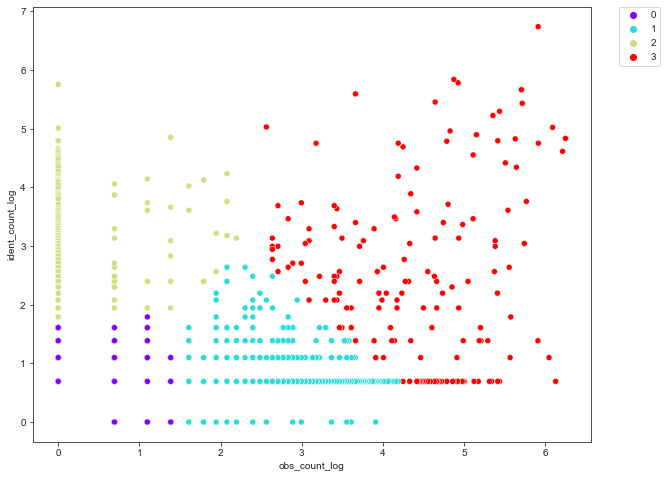

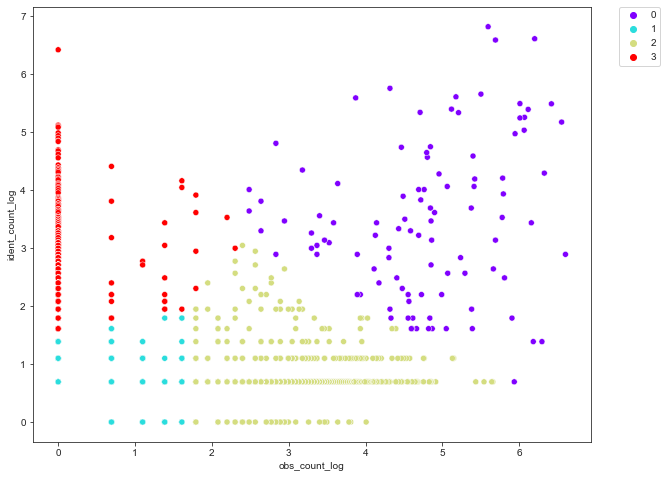

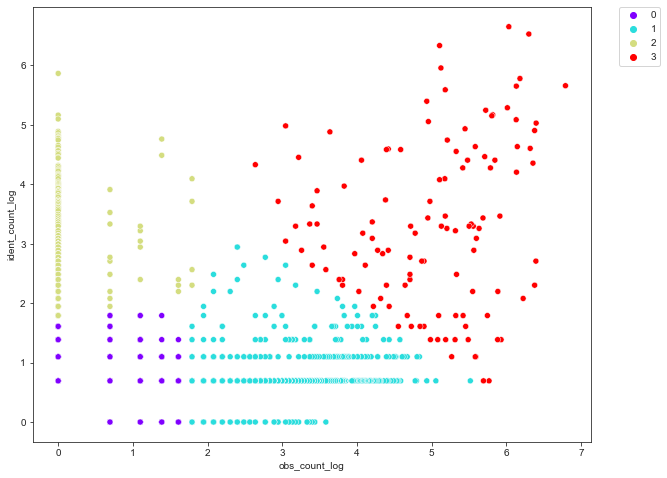

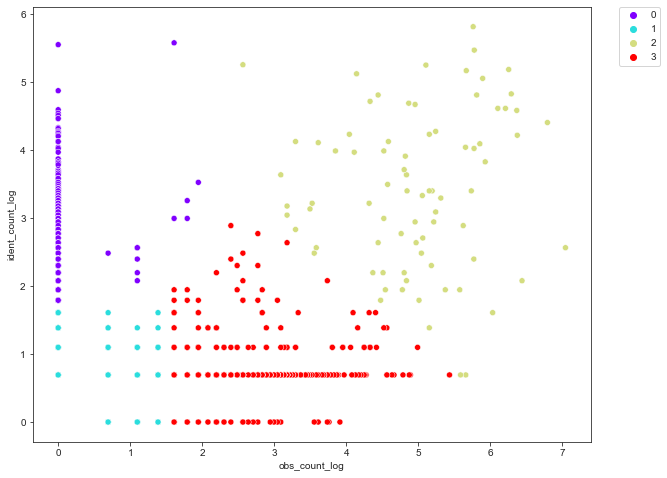

In [62]:
#san francisco
cluster_2d(df_sf_20, 'obs_count_log', 'ident_count_log', 4)
cluster_2d(df_sf_19, 'obs_count_log', 'ident_count_log', 4)
cluster_2d(df_sf_18, 'obs_count_log', 'ident_count_log', 4)
cluster_2d(df_sf_17, 'obs_count_log', 'ident_count_log', 4)

In [ ]:
cluster_2d(df_sf, 'obs_count_log', 'ident_count_log', 4)

In [ ]:
df_as_sf = df_sf.assign(cluster=(KMeans(n_clusters=4, n_init=10, init="random")
                           .fit(df_sf[["obs_count_log", "ident_count_log"]])
                           .predict(df_sf[["obs_count_log", "ident_count_log"]])))

In [ ]:
df_as_sf.drop(["user_id", "year", "obs_count", "ident_count", "obs_count_1", "ident_count_1"], axis=1).groupby("cluster").describe().transpose()

### Los Angeles

In [ ]:
cluster_2d(df_la, "obs_count_log", "ident_count_log", 4)

In [ ]:
df_as_la = df_la.assign(cluster=(KMeans(n_clusters=4, n_init=10, init="random")
                           .fit(df_la[["obs_count_log", "ident_count_log"]])
                           .predict(df_la[["obs_count_log", "ident_count_log"]])))

In [ ]:
df_as_sf.drop(["user_id", "year", "obs_count", "ident_count", "obs_count_1", "ident_count_1"], axis=1).groupby("cluster").describe().transpose()

### London

In [ ]:
cluster_2d(df_ldn, "obs_count_log", "ident_count_log", 4)

In [ ]:
df_as_ldn = df_ldn.assign(cluster=(KMeans(n_clusters=4, n_init=10, init="random")
                           .fit(df_ldn[["obs_count_log", "ident_count_log"]])
                           .predict(df_ldn[["obs_count_log", "ident_count_log"]])))

In [ ]:
df_as_ldn.drop(["user_id", "year", "obs_count", "ident_count", "obs_count_1", "ident_count_1"], axis=1).groupby("cluster").describe().transpose()

# 3D Clustering (all cities)

In [ ]:
X2 = df[["obs_count", "ident_count", "year"]]

In [ ]:
clusters2 = KMeans(n_clusters=6).fit(X2)

In [ ]:
scatter = go.Scatter3d(x=X2["obs_count"],
                     y=X2["ident_count"],
                     z=X2["year"],
                     mode="markers",
                     marker={"color": clusters2.predict(X2),
                             "size": 3,
                             "line": {"color": clusters2.predict(X2),
                                      "width":6}});

layout = go.Layout(title="Clusters",
                   scene={"xaxis": {"title": "obs_count"},
                          "yaxis": {"title": "ident_count"},
                          "zaxis": {"title": "year"}});

fig = go.Figure(data=scatter, layout=layout);
plotly.offline.iplot(fig)